In [251]:
from pathlib import Path
from glob import glob

# Standard library
import os
import random
import hashlib

# Third-party libraries
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import imagehash
import shutil
from sklearn.neighbors import NearestNeighbors

In [252]:
outdir = Path("results")
if outdir.exists():
    shutil.rmtree(outdir)
    
outdir.mkdir(parents=True, exist_ok=True)

## Load images from folder


In [253]:
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def load_images_from_folder(folder):
    images = []
    labels = []
    categories = []        
    image_paths = []       

    for label, className in enumerate(CLASS_NAMES):
        class_folder = os.path.join(folder, className)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))

            rel_path = "/" + os.path.join(className, filename)
            images.append(img)
            labels.append(label)
            categories.append(className)
            image_paths.append(rel_path)

    return (
        np.array(images, dtype=np.uint8),
        np.array(labels, dtype=np.int64),
        np.array(categories, dtype=object),
        np.array(image_paths, dtype=object)
    )

In [254]:
X_train, y_train, train_categories, train_paths = load_images_from_folder('intel-image-classification/seg_train/seg_train/')
X_test, y_test, categories_test, test_paths = load_images_from_folder('intel-image-classification/seg_test/seg_test/')

In [255]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14034, 128, 128, 3) (14034,)
(3000, 128, 128, 3) (3000,)


## Detect Misplaced Images

In [256]:
import numpy as np
import cv2

def extract_hsv_hist_features(images, h_bins=8, s_bins=8, v_bins=8):
    """
    images: np.array of shape (N, 128, 128, 3) in RGB, uint8 (from your loader)
    returns: np.array of shape (N, h_bins * s_bins * v_bins) of float32
    """
    features = []

    for img in images:
        # img is RGB from your loader; convert to HSV for better color separation
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # 3D histogram over H, S, V
        hist = cv2.calcHist(
            [hsv],
            channels=[0, 1, 2],
            mask=None,
            histSize=[h_bins, s_bins, v_bins],
            ranges=[0, 180, 0, 256, 0, 256]
        )

        # Normalize histogram and flatten
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)

    return np.array(features, dtype=np.float32)


In [257]:
train_features = extract_hsv_hist_features(X_train)

In [258]:
# 1. Remove pyarrow (it’s optional for scikit-learn and currently broken)
%pip uninstall -y pyarrow

# 2. Downgrade numpy back to a 1.x version that works with everything
%pip install "numpy<2.0" --force-reinstall


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=

In [259]:
def find_suspicious_by_knn(
    features,
    labels,
    paths,
    k=20,
    neighbor_diff_threshold=0.8,
    min_alt_frac=0.6,
    max_per_class=None,
):
    """
    features: np.array (N, D) feature vectors
    labels:   np.array (N,) int labels (0..C-1)
    paths:    np.array (N,) strings like "/forest/2121.png"
    k:        number of neighbors (excluding self)
    neighbor_diff_threshold:
        fraction of neighbors with a different label than the sample
        (e.g. 0.8 means: at least 80% of neighbors disagree with its label)
    min_alt_frac:
        among neighbors with a *different* label, the majority alternative label
        must cover at least this fraction of ALL neighbors.
        (forces neighbors to mostly agree on *one* other class)
    max_per_class:
        if not None, keep at most this many most suspicious samples per class.

    returns:
        suspicious_indices: np.array of indices into features/labels/paths
        disagreement_scores: np.array of floats in [0,1] (frac of neighbors that disagree)
    """
    n_neighbors = k + 1  # +1 because first neighbor will be the sample itself

    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    nn.fit(features)

    distances, indices = nn.kneighbors(features)

    # Collect candidates per true class (for optional max_per_class)
    classes = np.unique(labels)
    per_class_candidates = {c: [] for c in classes}

    for i in range(features.shape[0]):
        neigh_idx = indices[i, 1:]          # exclude self
        neigh_labels = labels[neigh_idx]

        # fraction of neighbors with a different label
        frac_diff = np.mean(neigh_labels != labels[i])
        if frac_diff < neighbor_diff_threshold:
            continue

        # now check if neighbors mostly agree on a single alternative class
        alt_labels = neigh_labels[neigh_labels != labels[i]]
        if alt_labels.size == 0:
            continue

        values, counts = np.unique(alt_labels, return_counts=True)
        alt_majority_frac = counts.max() / k

        if alt_majority_frac < min_alt_frac:
            # neighbors disagree with the label but are not consistent about *which* other class it is
            continue

        # candidate accepted
        true_class = labels[i]
        per_class_candidates[true_class].append((i, frac_diff, alt_majority_frac))

    # Flatten candidates, possibly limiting per class
    selected_indices = []
    selected_scores = []

    for c, cand_list in per_class_candidates.items():
        if not cand_list:
            continue

        # sort by disagreement score (frac_diff) descending
        cand_list_sorted = sorted(cand_list, key=lambda t: t[1], reverse=True)

        if max_per_class is not None:
            cand_list_sorted = cand_list_sorted[:max_per_class]

        for idx, frac_diff, alt_frac in cand_list_sorted:
            selected_indices.append(idx)
            selected_scores.append(frac_diff)

    if len(selected_indices) == 0:
        return np.array([], dtype=int), np.array([], dtype=float)

    selected_indices = np.array(selected_indices, dtype=int)
    selected_scores = np.array(selected_scores, dtype=float)

    return selected_indices, selected_scores

In [260]:
sus_train_idx, train_scores = find_suspicious_by_knn(
    train_features,
    y_train,
    train_paths,
    k=20,                     # more neighbors → more stable
    neighbor_diff_threshold=0.85,  # require stronger disagreement
    min_alt_frac=0.7,         # neighbors must mostly agree on *one* alt class
    max_per_class=150         # optional cap: at most 150 per true class
)

print("Suspicious train images:", len(sus_train_idx))

Suspicious train images: 487


In [261]:
def plot_suspicious_images(
    X,
    y,
    paths,
    suspicious_indices,
    scores=None,
    class_names=None,
    max_images_per_class=40,
    cols=5,
    figsize=(15, 12)
):
    """
    Plots suspicious images grouped by category (class).

    For each class that has suspicious images, this creates one figure with a
    grid of subplots (all same size), 5 images per row by default.

    X:       images (N, H, W, 3), RGB uint8 or float [0,1]
    y:       labels (N,) int, assumed 0..C-1
    paths:   (N,) paths like "/forest/2121.png"
    suspicious_indices: indices into X/y/paths
    scores:  optional disagreement scores (same length as suspicious_indices);
             used only to sort within each class (highest score first)
    class_names: list of class names, len = number of classes. If None, uses str(index).
    """

    if len(suspicious_indices) == 0:
        print("No suspicious images found with current settings.")
        return

    suspicious_indices = np.array(suspicious_indices)

    if scores is not None:
        scores = np.asarray(scores)
        if len(scores) != len(suspicious_indices):
            raise ValueError("scores must have same length as suspicious_indices")

    # Infer class names if not given
    if class_names is None:
        num_classes = int(y.max()) + 1
        class_names = [str(i) for i in range(num_classes)]

    # Loop over classes and plot one figure per class
    for class_idx, class_name in enumerate(class_names):
        mask = (y[suspicious_indices] == class_idx)
        if not np.any(mask):
            continue  # no suspicious images for this class

        class_susp_indices = suspicious_indices[mask]
        class_scores = scores[mask] if scores is not None else None

        # Sort within this class by score descending, if scores are provided
        if class_scores is not None:
            order = np.argsort(-class_scores)
            class_susp_indices = class_susp_indices[order]
            class_scores = class_scores[order]

        # Limit per class
        class_susp_indices = class_susp_indices[:max_images_per_class]
        n = len(class_susp_indices)
        rows = math.ceil(n / cols)

        print(f"{class_name}: {n} suspicious images")

        # Regular grid: all subplots same size
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = np.array(axes).reshape(-1)

        for ax_i, idx in enumerate(class_susp_indices):
            ax = axes[ax_i]
            img = X[idx]

            # Ensure uint8 0–255 for display
            if img.dtype != np.uint8:
                img = (np.clip(img, 0, 1) * 255).astype(np.uint8)

            ax.imshow(img)
            ax.axis("off")

            # Strip leading "/" from paths
            path_str = str(paths[idx])
            if path_str.startswith("/"):
                path_str = path_str[1:]

            ax.set_title(path_str, fontsize=7, pad=6)

        # Turn off any unused axes in the grid
        for ax in axes[n:]:
            ax.axis("off")

        # Small horizontal spacing, more vertical spacing for titles + suptitle
        fig.subplots_adjust(
            wspace=0.1,   # almost no horizontal space between images
            hspace=0.2      # more vertical space so titles are clearly visible
        )

        plt.show()


0: 40 suspicious images


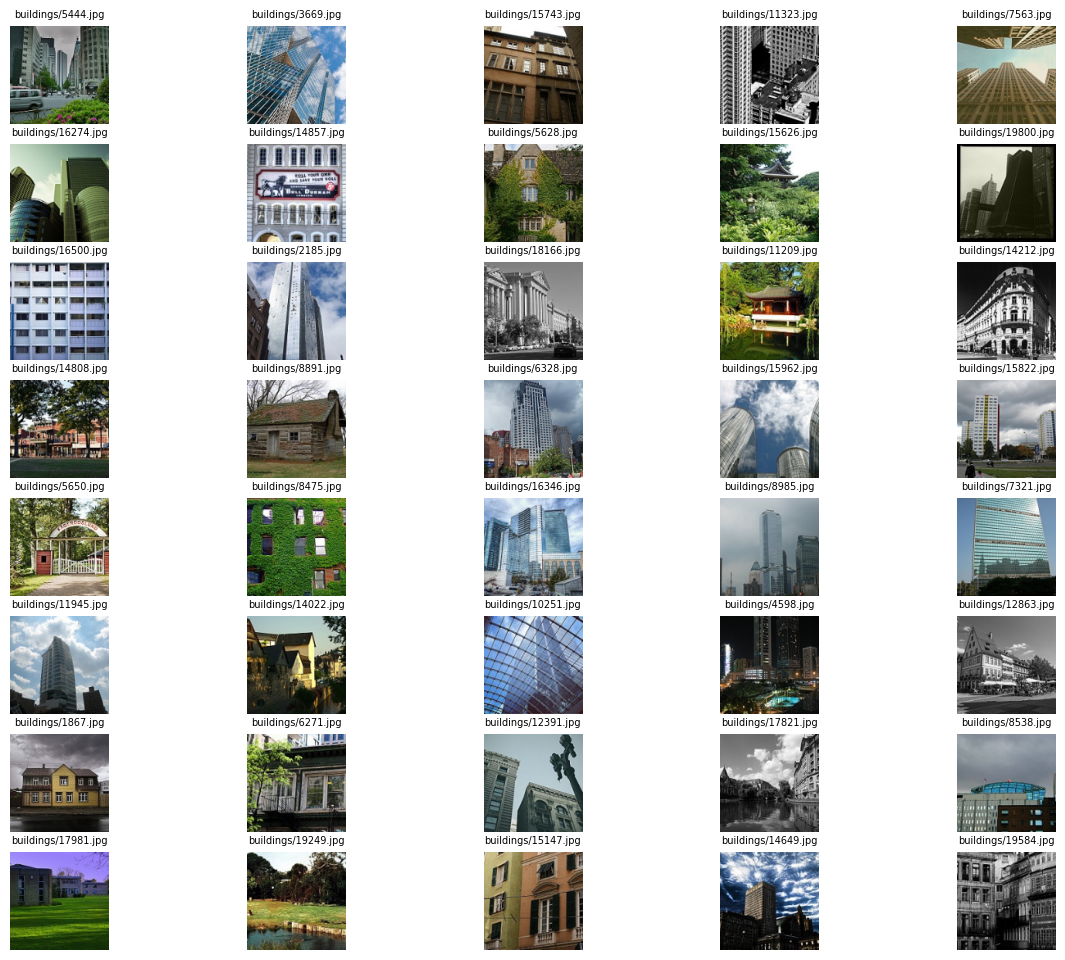

1: 15 suspicious images


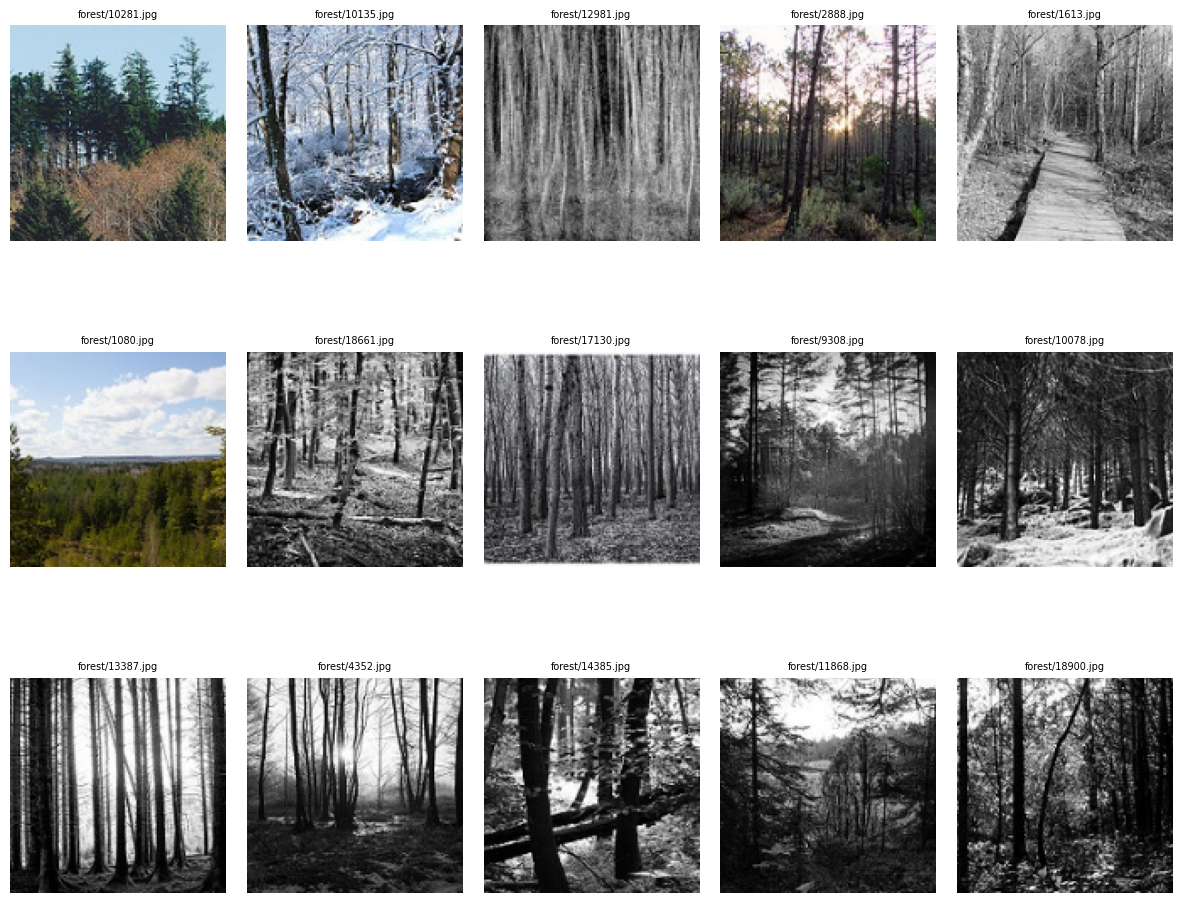

2: 40 suspicious images


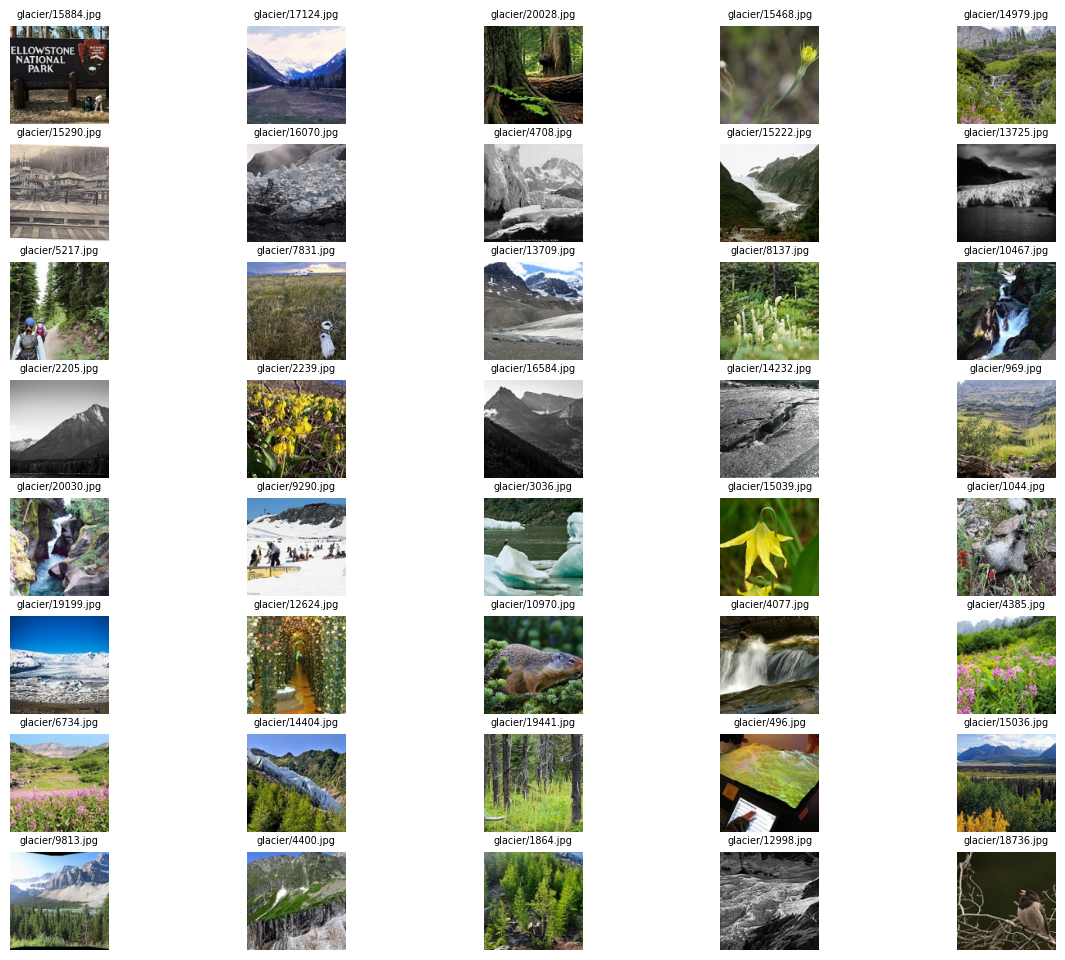

3: 40 suspicious images


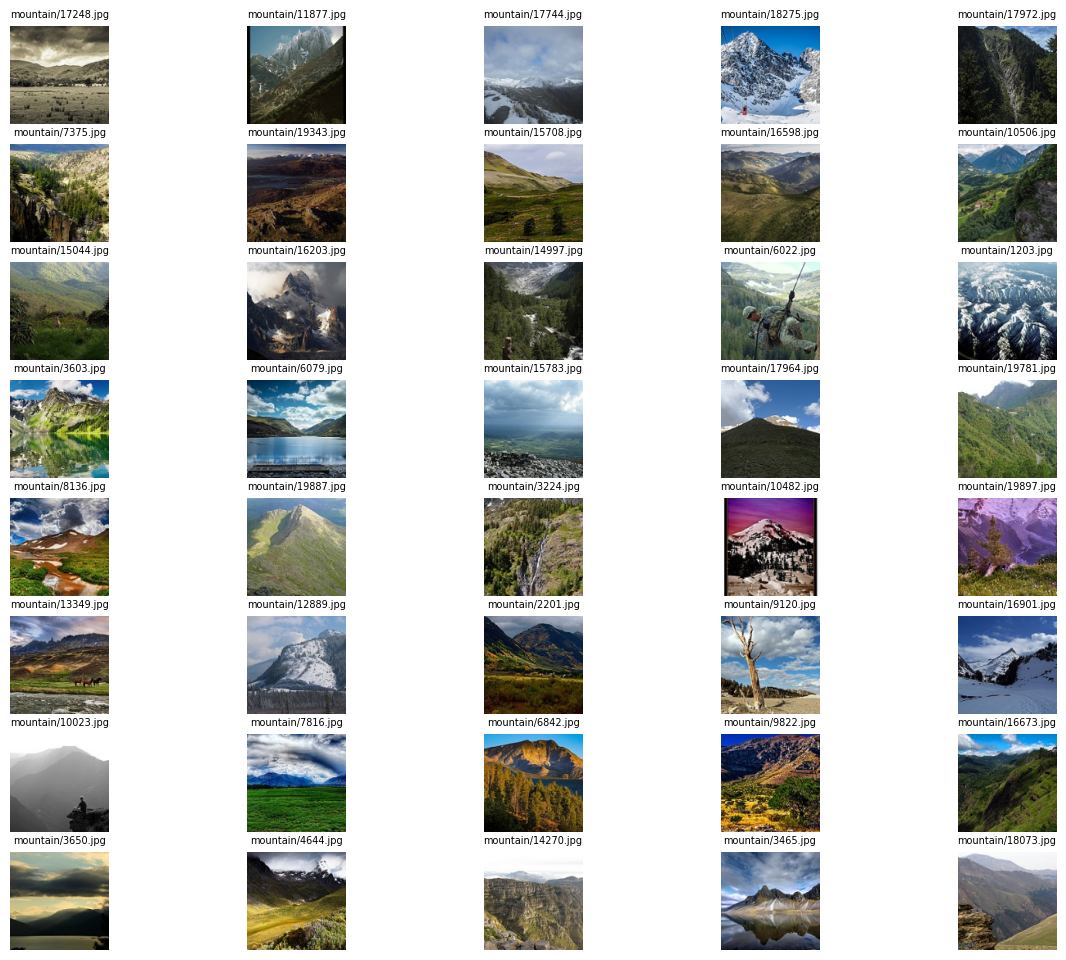

4: 40 suspicious images


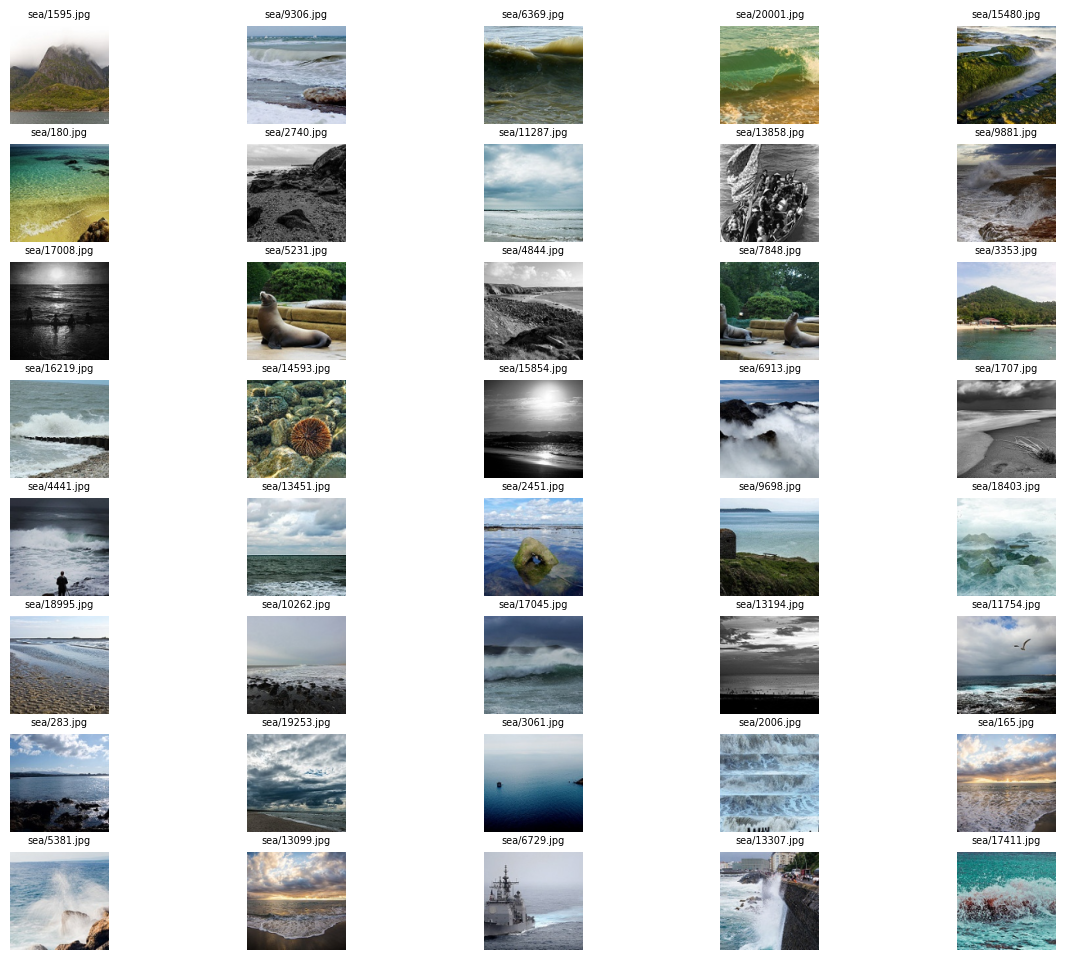

5: 40 suspicious images


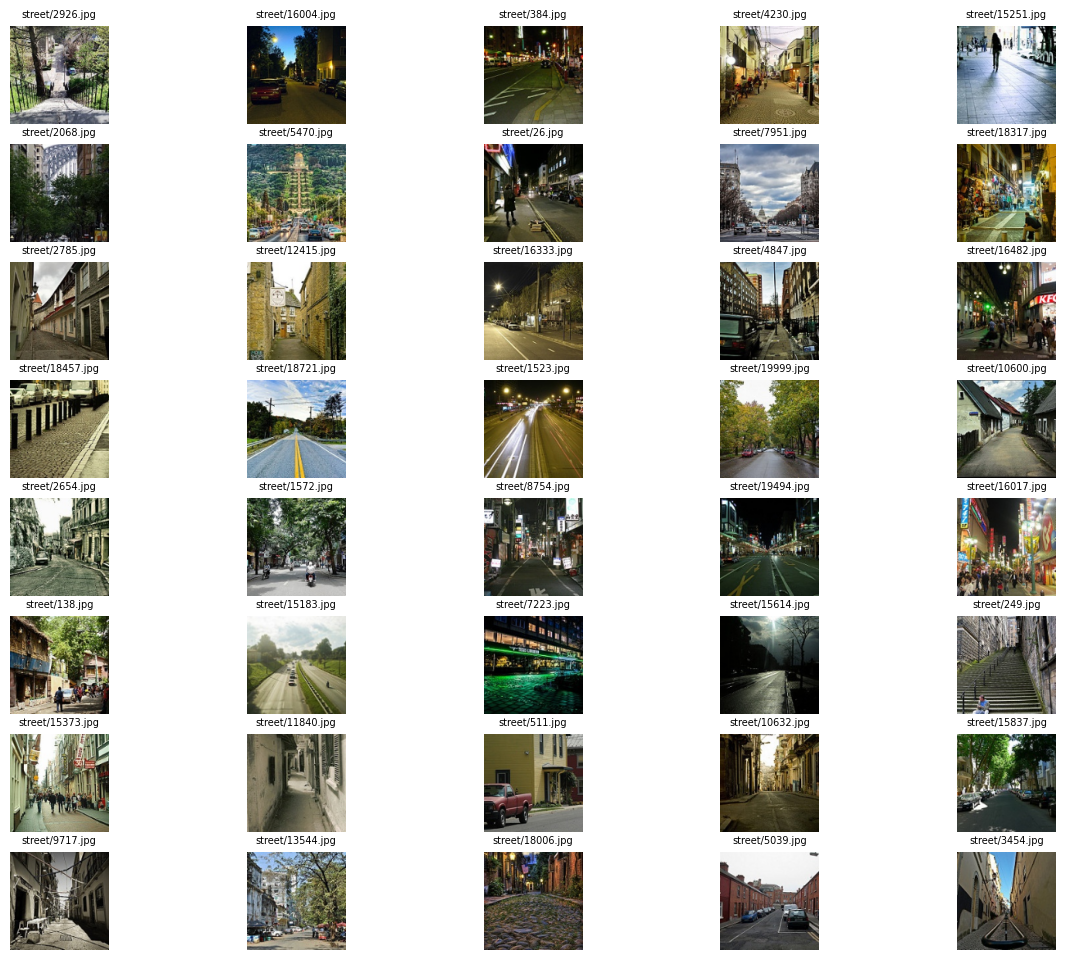

In [262]:
CLASS_NAMES = ['buildings', 'glacier', 'mountain', 'sea', 'street', 'forest']

plot_suspicious_images(X_train, y_train, train_paths, suspicious_indices=sus_train_idx, scores=train_scores)

## Clean Training Set

In [263]:
def find_exact_duplicates(images, paths):
    """Find exact duplicate images using MD5 hashing on raw bytes."""
    hash_dict = {}
    dup_groups = []
    keep_mask = np.ones(len(images), dtype=bool)

    for i, img in enumerate(images):
        h = hashlib.md5(img.tobytes()).hexdigest()
        if h in hash_dict:
            first_idx = hash_dict[h]
            keep_mask[i] = False

            found_group = False
            for group in dup_groups:
                if paths[first_idx] in group:
                    group.append(paths[i])
                    found_group = True
                    break
            if not found_group:
                dup_groups.append([paths[first_idx], paths[i]])
        else:
            hash_dict[h] = i

    return keep_mask, dup_groups

def find_grayscale_duplicates(images, paths):
    """Find grayscale duplicate images via MD5 hashing on grayscale pixels."""
    hash_dict = {}
    dup_groups = []
    keep_mask = np.ones(len(images), dtype=bool)

    for i, img in enumerate(images):
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        h = hashlib.md5(gray_img.tobytes()).hexdigest()
        if h in hash_dict:
            first_idx = hash_dict[h]
            keep_mask[i] = False

            found_group = False
            for group in dup_groups:
                if paths[first_idx] in group:
                    group.append(paths[i])
                    found_group = True
                    break
            if not found_group:
                dup_groups.append([paths[first_idx], paths[i]])
        else:
            hash_dict[h] = i

    return keep_mask, dup_groups

def find_perceptual_duplicates(
    images,
    paths,
    threshold=0,
    hash_func=imagehash.phash,
):
    """
    Find perceptual duplicate images using a perceptual hash.

    threshold:
        Maximum Hamming distance between hashes to consider images duplicates.
        For scene datasets like Intel, keep this at 0 (exact hash matches only)
        to avoid killing natural variation.
    hash_func:
        imagehash function to use (default: phash, better than average_hash here).
    """
    hash_dict = {}
    dup_groups = []
    keep_mask = np.ones(len(images), dtype=bool)

    for i, img in enumerate(images):
        pil_img = Image.fromarray(img)
        h = hash_func(pil_img)

        if threshold == 0:
            # Fast path: only exact hash matches
            if h in hash_dict:
                first_idx = hash_dict[h]
                keep_mask[i] = False

                found_group = False
                for group in dup_groups:
                    if paths[first_idx] in group:
                        group.append(paths[i])
                        found_group = True
                        break
                if not found_group:
                    dup_groups.append([paths[first_idx], paths[i]])
            else:
                hash_dict[h] = i
        else:
            # More permissive path: check Hamming distance to existing hashes
            found_duplicate = False
            for existing_hash in hash_dict:
                if h - existing_hash <= threshold:
                    first_idx = hash_dict[existing_hash]
                    keep_mask[i] = False
                    found_duplicate = True

                    found_group = False
                    for group in dup_groups:
                        if paths[first_idx] in group:
                            group.append(paths[i])
                            found_group = True
                            break
                    if not found_group:
                        dup_groups.append([paths[first_idx], paths[i]])
                    break

            if not found_duplicate:
                hash_dict[h] = i

    return keep_mask, dup_groups

def is_low_edge(img, edge_ratio_thresh=0.01):
    """Checks if an image has a low edge ratio using Canny edge detection."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_pixels = np.sum(edges > 0)
    total_pixels = edges.size
    edge_ratio = edge_pixels / total_pixels
    return edge_ratio < edge_ratio_thresh

def is_almost_constant(img, std_thresh=5.0):
    """Checks if an image is almost constant based on grayscale standard deviation."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    stddev = np.std(gray)
    return stddev < std_thresh

def is_too_noisy(img, noise_std_thresh=None):
    """
    Checks if an image is too noisy based on Laplacian stddev.

    For natural scenes (buildings, forest, etc.), this is often *not* useful.
    If noise_std_thresh is None, this check is disabled.
    """
    if noise_std_thresh is None:
        return False

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    noise_std = np.std(laplacian)
    return noise_std > noise_std_thresh

def is_blurry(img, std_thresh=100.0):
    """Checks if an image is blurry based on the variance of the Laplacian."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    return variance < std_thresh

In [264]:
def clean_training_set(
    X,
    y,
    categories,
    paths,
    *,
    perceptual_threshold=0,
    low_edge_ratio_thresh=0.003,  # More conservative for natural scenes
    constant_std_thresh=2.5,      # Slightly stricter for truly blank images
    noise_std_thresh=None,        # disable noisy filter by default
    blur_std_thresh=50.0,         # Stricter blur detection (was 80)
    crop_match_threshold=12,      # Perceptual hash distance for crop matching
):
    """
    Detect potential issues (duplicates, empty/constant/noisy/blurry images)
    in the Intel scene dataset.

    IMPORTANT:
    - This version does NOT remove any images from the dataset.
    - X_clean, y_clean, categories_clean, paths_clean are identical to the inputs.
    - All detected issues are returned via the `info` dict for analysis/plotting.

    Returns:
      X_clean, y_clean, categories_clean, paths_clean, keep_mask, info
    """
    n = len(X)

    # We keep all images; keep_mask is all True and never changed
    keep_mask = np.ones(n, dtype=bool)

    # 1) Exact duplicates (detected for reporting/plotting only)
    exact_mask, exact_dup_groups = find_exact_duplicates(X, paths)

    # 2) Grayscale duplicates (detected for reporting/plotting only)
    gray_mask, gray_dup_groups = find_grayscale_duplicates(X, paths)

    # 3) Perceptual duplicates (detected for reporting/plotting only)
    phash_mask, phash_dup_groups = find_perceptual_duplicates(
        X,
        paths,
        threshold=perceptual_threshold,
    )

    removed_empty = []
    removed_constant = []
    removed_noisy = []
    removed_blurry = []

    # 4–7) Detect other problematic images (but do NOT remove them)
    for i in range(n):
        img = X[i]

        # Empty / almost-empty
        if is_low_edge(img, edge_ratio_thresh=low_edge_ratio_thresh):
            removed_empty.append(paths[i])
            continue

        # Almost constant (e.g. plain black/white)
        if is_almost_constant(img, std_thresh=constant_std_thresh):
            removed_constant.append(paths[i])
            continue

        # Too noisy / unrecognizable (disabled if noise_std_thresh is None)
        if is_too_noisy(img, noise_std_thresh=noise_std_thresh):
            removed_noisy.append(paths[i])
            continue

        # Very blurry (low Laplacian variance)
        if is_blurry(img, std_thresh=blur_std_thresh):
            removed_blurry.append(paths[i])
            continue

    # Build "cleaned" arrays – identical to original, since we keep everything
    X_clean = X
    y_clean = y
    categories_clean = categories
    paths_clean = paths

    # Collect info for analysis/plotting
    info = {
        "exact_duplicate_groups": exact_dup_groups,
        "grayscale_duplicate_groups": gray_dup_groups,
        "perceptual_duplicate_groups": phash_dup_groups,
        "removed_empty": removed_empty,
        "removed_constant": removed_constant,
        "removed_noisy": removed_noisy,
        "removed_blurry": removed_blurry,
    }

    return X_clean, y_clean, categories_clean, paths_clean, keep_mask, info

In [265]:
def show_removed_images(paths_list, title, X, paths, n_cols=3, save_name=None):
    if len(paths_list) == 0:
        return

    # Only show up to n_cols examples
    indices = [np.where(paths == p)[0][0] for p in paths_list[:n_cols] if p in paths]
    if len(indices) == 0:
        return

    fig, axes = plt.subplots(1, len(indices), figsize=(3 * len(indices), 3))
    if len(indices) == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx])
        axes[i].set_title(f'{paths[idx]}', fontsize=8)
        axes[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()

    if save_name:
        save_path = Path(save_name)
        folder = Path(outdir) / save_path.stem
        folder.mkdir(parents=True, exist_ok=True)

        outpath = folder / save_path.name
        plt.savefig(outpath)

    # plt.show()
    plt.close(fig)

def show_duplicate_groups(dup_groups, X, paths, title, save_name=None):
    """
    Plot all duplicate pairs in a single figure.

    Layout:
      - Each ROW has 6 images = 3 pairs of duplicates.
      - All pairs from all groups are placed into this grid.
    """
    if not dup_groups:
        return

    # Build list of (idx1, idx2) pairs from the groups
    pairs = []
    for group in dup_groups:
        group_paths = [p for p in group if p in paths]
        if len(group_paths) < 2:
            continue

        # Pair consecutive items: (p0,p1), (p2,p3), ...
        for i in range(0, len(group_paths) - 1, 2):
            p1 = group_paths[i]
            p2 = group_paths[i + 1]
            idx1 = np.where(paths == p1)[0][0]
            idx2 = np.where(paths == p2)[0][0]
            pairs.append((idx1, idx2))

        # If odd number of images in group, last one is ignored (no partner).

    if not pairs:
        return

    n_pairs = len(pairs)
    pairs_per_row = 3          # 3 pairs per row
    n_cols = 6                 # 6 images per row (3 pairs)
    n_rows = int(np.ceil(n_pairs / pairs_per_row))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    # Hide all axes to start
    for ax in axes.ravel():
        ax.axis('off')

    for pair_idx, (idx1, idx2) in enumerate(pairs):
        row = pair_idx // pairs_per_row
        col_start = (pair_idx % pairs_per_row) * 2  # (0, 2, 4)

        ax1 = axes[row, col_start]
        ax2 = axes[row, col_start + 1]

        ax1.imshow(X[idx1])
        ax1.set_title(f'{paths[idx1]}', fontsize=8)
        ax1.axis('off')

        ax2.imshow(X[idx2])
        ax2.set_title(f'{paths[idx2]}', fontsize=8)
        ax2.axis('off')

    plt.suptitle(title)
    plt.tight_layout()

    if save_name:
        folder = Path(outdir) / save_name
        folder.mkdir(parents=True, exist_ok=True)
        outpath = folder / f'{save_name}_pairs.png'
        plt.savefig(outpath)

    # plt.show()
    plt.close(fig)

In [266]:
print("Train shape before cleaning:", X_train.shape)

(
  X_train_clean, 
  y_train_clean, 
  train_categories_clean,
  train_paths_clean, 
  train_keep_mask, 
  clean_info 
) = clean_training_set(X_train, y_train, train_categories, train_paths)

print("Train shape after cleaning:", X_train_clean.shape)

info_table = pd.DataFrame({
    'Type': [
        'Exact Duplicates',
        'Grayscale Duplicates',
        'Perceptual Duplicates',
        'Empty/Low Edge',
        'Almost Constant',
        'Too Noisy',
        'Blurry',
    ],
    'Count': [
        sum(len(g) for g in clean_info['exact_duplicate_groups']),
        sum(len(g) for g in clean_info['grayscale_duplicate_groups']),
        sum(len(g) for g in clean_info['perceptual_duplicate_groups']),
        len(clean_info['removed_empty']),
        len(clean_info['removed_constant']),
        len(clean_info['removed_noisy']),
        len(clean_info['removed_blurry']),
    ]
})
display(info_table)


Train shape before cleaning: (14034, 128, 128, 3)
Train shape after cleaning: (14034, 128, 128, 3)
Train shape after cleaning: (14034, 128, 128, 3)


Type  Count
0       Exact Duplicates     30
1   Grayscale Duplicates     30
2  Perceptual Duplicates     80
3         Empty/Low Edge      8
4        Almost Constant      0
5              Too Noisy      0
6                 Blurry      6

In [267]:
# All duplicate pairs (for each type) in single figures, with 4 images (2 pairs) per row
show_duplicate_groups(
    clean_info['exact_duplicate_groups'],
    X_train,
    train_paths,
    'Exact Duplicates',
    save_name='exact_duplicates'
)

show_duplicate_groups(
    clean_info['grayscale_duplicate_groups'],
    X_train,
    train_paths,
    'Grayscale Duplicates',
    save_name='grayscale_duplicates'
)

show_duplicate_groups(
    clean_info['perceptual_duplicate_groups'],
    X_train,
    train_paths,
    'Perceptual Duplicates',
    save_name='perceptual_duplicates'
)

# Example images for each "problem" category (still just illustrative, no removals)
show_removed_images(
    clean_info['removed_empty'],
    'Empty/Low Edge Images',
    X_train,
    train_paths,
    n_cols=6,
    save_name='empty_low_edge_examples.png'
)

show_removed_images(
    clean_info['removed_constant'],
    'Almost Constant Images',
    X_train,
    train_paths,
    n_cols=6,
    save_name='almost_constant_examples.png'
)

show_removed_images(
    clean_info['removed_noisy'],
    'Too Noisy Images',
    X_train,
    train_paths,
    n_cols=6,
    save_name='too_noisy_examples.png'
)

show_removed_images(
    clean_info['removed_blurry'],
    'Blurry Images',
    X_train,
    train_paths,
    n_cols=6,
    save_name='blurry_examples.png'
)

## Extract features from images

In [268]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm

def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
        
        # feats.append(np.concatenate([fd, lbp_hist, edges]))
        feats.append(np.concatenate([fd, lbp_hist]))
    return np.asarray(feats, dtype=np.float32)

# X_train_feats = extract_features(X_train)
# X_test_feats = extract_features(X_test)
# y_train_feats = y_train.copy()
# y_test_feats = y_test.copy()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject